In [1]:
import datetime
import json
import time
from pathlib import Path
from typing import List, Tuple, Union

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from numpy.typing import NDArray
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data.sampler import Sampler
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.io import ImageReadMode, read_image
from torchvision.models import (
    EfficientNet_V2_S_Weights,
    MobileNet_V3_Large_Weights,
    MobileNet_V3_Small_Weights,
    ResNet50_Weights,
    efficientnet_v2_l,
    mobilenet_v3_large,
    mobilenet_v3_small,
    resnet50,
)
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.transforms import RandomCrop, Resize, transforms
from torchvision.transforms.functional import crop
from tqdm import tqdm

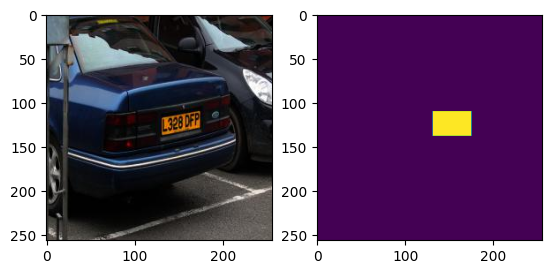

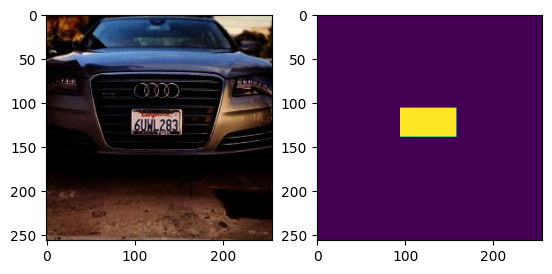

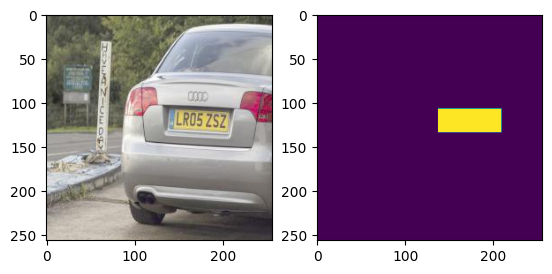

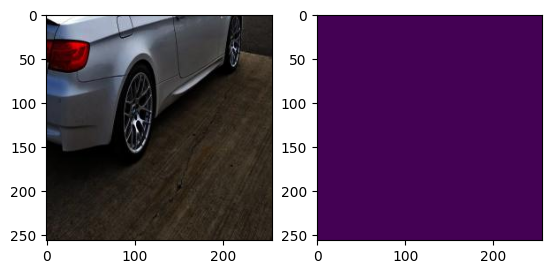

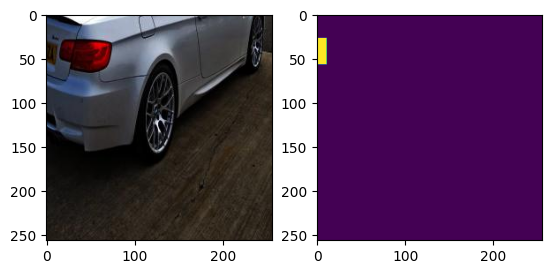

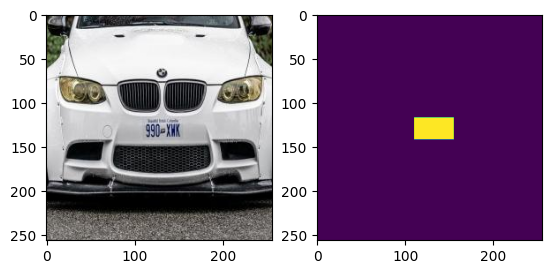

In [9]:
class LicensePlateDataset(Dataset):
    def __init__(self, directory, is_train=True):
        if directory is None:
            print("Directory is none")
            return
        self.directory = Path(directory)
        self.image_label = []
        if is_train:
            self.decode(
                file_path=str(self.directory.joinpath("train/_annotations.coco.json")),
                is_train=is_train,
            )
        else:
            self.decode(
                file_path=str(self.directory.joinpath("valid/_annotations.coco.json")),
                is_train=is_train,
            )

    def decode(self, file_path: str, is_train=True):
        with open(file_path) as file:
            jsonData = json.load(file)
            for image in jsonData["images"]:
                image_id = image["id"]
                image_filename = image["file_name"]
                for annotation in jsonData["annotations"]:
                    # if annotation["image_id"] == image_id and annotation['category_id'] == "1":
                    if annotation["image_id"] == image_id and (
                        annotation["category_id"] == 1 or annotation["category_id"] == 0
                    ):
                        bounding_box = annotation["bbox"]
                        x1, y1 = int(bounding_box[0]), int(bounding_box[1])
                        x2, y2 = x1 + int(bounding_box[2]), y1 + int(bounding_box[3])
                        self.image_label.append(
                            {
                                "image_filename": f'{"train" if is_train else "valid"}/{image_filename}',
                                "bbox": [x1, y1, x2, y2],
                            }
                        )

    def __len__(self):
        return len(self.image_label)

    def __getitem__(self, index):
        image = self.decode_image(
            str(self.directory.joinpath(f"{self.image_label[index]['image_filename']}"))
        )

        mask = torch.zeros([1, image.size(1), image.size(2)])
        x1, y1, x2, y2 = self.image_label[index]["bbox"]
        _, w, h = mask[..., y1:y2, x1:x2].size()
        mask[..., y1:y2, x1:x2] = torch.tensor([1]).repeat(1, w, h)

        i, j, h, w = RandomCrop.get_params(image, (256, 256))
        # Crop image and label
        image = crop(image, i, j, h, w)
        mask = crop(mask, i, j, h, w)

        masked = torch.cat([mask, torch.abs(1 - mask)])
        return image.to(torch.float32) / 255, masked.to(torch.float32)

    @staticmethod
    def decode_image(image_path):
        return read_image(image_path, ImageReadMode.RGB)


for idx, sample in enumerate(
    LicensePlateDataset("/Users/babi/Downloads/license_plate")
):
    fig, axes = plt.subplots(ncols=2)
    axes[0].imshow(torch.permute(sample[0], [1, 2, 0]))
    axes[1].imshow(sample[1][0])

    if idx == 5:
        break

torch.Size([1, 2, 256, 256])


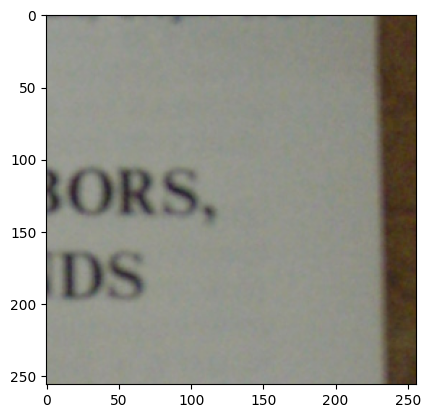

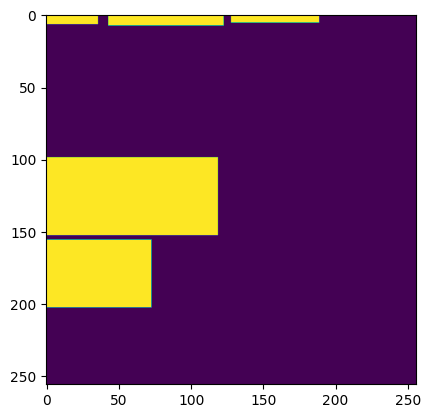

In [106]:
class TextOCRDataset(Dataset):
    def __init__(self, directory, is_train=True):
        if directory == None:
            print("Directory is none")
            return
        self.directory = Path(directory)
        self.images = []
        self.labels = []
        self.area = []
        if is_train:
            self.decode(
                file_path=str(self.directory.joinpath("TextOCR_0.1_train.json"))
            )
        else:
            self.decode(file_path=str(self.directory.joinpath("TextOCR_0.1_val.json")))

    def decode(self, file_path: str):
        validation_label = json.load(open(file_path))
        for image_id, image in validation_label["imgToAnns"].items():
            bounding_box_each_image = []
            area_sum = 0
            for annotation in image:
                annot = validation_label["anns"][f"{annotation}"]
                bounding_box = annot["bbox"]
                x1, y1 = int(bounding_box[0]), int(bounding_box[1])
                x2, y2 = x1 + int(bounding_box[2]), y1 + int(bounding_box[3])
                bounding_box_each_image.append([x1, y1, x2, y2])
                area_sum += float(annot["area"])
            self.images.append(image_id)
            self.labels.append(bounding_box_each_image)
            self.area.append(area_sum)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.decode_image(
            str(self.directory.joinpath("train_images", f"{self.images[index]}.jpg"))
        )
        mask = torch.zeros([1, image.size(1), image.size(2)])
        for bounding_box in self.labels[index]:
            x1, y1, x2, y2 = bounding_box
            _, w, h = mask[..., y1:y2, x1:x2].size()
            mask[..., y1:y2, x1:x2] = torch.tensor([1]).repeat(1, w, h)

        i, j, h, w = RandomCrop.get_params(image, (256, 256))
        # Crop image and label
        image = crop(image, i, j, h, w)
        mask = crop(mask, i, j, h, w)

        masked = torch.cat([mask, torch.abs(1 - mask)])
        return image.to(torch.float32) / 255, masked.to(torch.float32)

    @staticmethod
    def decode_image(image_path):
        return read_image(image_path, ImageReadMode.RGB)


dataset = TextOCRDataset(directory="../data/dataset/", is_train=True)
areas = torch.tensor(dataset.area)
indices = torch.nonzero(areas > 80000.54)[..., 0]
subset = Subset(dataset=dataset, indices=indices.tolist())
train_dataloader = DataLoader(subset, batch_size=1)
for idx, sample in enumerate(train_dataloader):
    print(sample[1].size())

    if idx == 0:
        break

# for i, sample in enumerate(dataset):
#     # if sample[0].size(0) == 1:
#     #     break
#     figures, axes = plt.subplots(1, 3)
#     axes[0].imshow(torch.permute(sample[0], dims=[1, 2, 0]))
#     axes[1].imshow(sample[1][0], cmap='gray')
#     axes[2].imshow(sample[1][1], cmap='gray')


#     if i == 5:
#         break

plt.imshow(torch.permute(sample[0][0], dims=[1, 2, 0]))
plt.figure()
plt.imshow(sample[1][0, 0])

In [ ]:
class TextOCRDataset(Dataset):
    def __init__(self, directory, is_train=True):
        if directory == None:
            print("Directory is none")
            return
        self.directory = Path(directory)
        self.images = []
        self.labels = []
        self.area = []
        if is_train:
            self.decode(
                file_path=str(self.directory.joinpath("TextOCR_0.1_train.json"))
            )
        else:
            self.decode(file_path=str(self.directory.joinpath("TextOCR_0.1_val.json")))

    def decode(self, file_path: str):
        validation_label = json.load(open(file_path))
        for image_id, image in validation_label["imgToAnns"].items():
            bounding_box_each_image = []
            area_sum = 0
            for annotation in image:
                annot = validation_label["anns"][f"{annotation}"]
                bounding_box = annot["bbox"]
                x1, y1 = int(bounding_box[0]), int(bounding_box[1])
                x2, y2 = x1 + int(bounding_box[2]), y1 + int(bounding_box[3])
                bounding_box_each_image.append([x1, y1, x2, y2])
                area_sum += float(annot["area"])
            self.images.append(image_id)
            self.labels.append(bounding_box_each_image)
            self.area.append(area_sum)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.decode_image(
            str(self.directory.joinpath("train_images", f"{self.images[index]}.jpg"))
        )
        mask = torch.zeros([1, image.size(1), image.size(2)])
        for bounding_box in self.labels[index]:
            x1, y1, x2, y2 = bounding_box
            _, w, h = mask[..., y1:y2, x1:x2].size()
            mask[..., y1:y2, x1:x2] = torch.tensor([1]).repeat(1, w, h)

        i, j, h, w = RandomCrop.get_params(image, (256, 256))
        # Crop image and label
        image = crop(image, i, j, h, w)
        mask = crop(mask, i, j, h, w)

        masked = torch.cat([mask, torch.abs(1 - mask)])
        return image.to(torch.float32) / 255, masked.to(torch.float32)

    @staticmethod
    def decode_image(image_path):
        return read_image(image_path, ImageReadMode.RGB)


dataset = TextOCRDataset(directory="../data/dataset/", is_train=True)
areas = torch.tensor(dataset.area)
indices = torch.nonzero(areas > 80000.54)[..., 0]
subset = Subset(dataset=dataset, indices=indices.tolist())
train_dataloader = DataLoader(subset, batch_size=1)
for idx, sample in enumerate(train_dataloader):
    print(sample[1].size())

    if idx == 0:
        break

# for i, sample in enumerate(dataset):
#     # if sample[0].size(0) == 1:
#     #     break
#     figures, axes = plt.subplots(1, 3)
#     axes[0].imshow(torch.permute(sample[0], dims=[1, 2, 0]))
#     axes[1].imshow(sample[1][0], cmap='gray')
#     axes[2].imshow(sample[1][1], cmap='gray')


#     if i == 5:
#         break

plt.imshow(torch.permute(sample[0][0], dims=[1, 2, 0]))
plt.figure()
plt.imshow(sample[1][0, 0])

In [3]:
# def combine_channels(image: torch.Tensor, colors: np.ndarray, is_predict: bool):
#     _, _, h, w = image.shape
#     output_image = np.zeros([h, w, 3], dtype=np.uint8)
#     for i in range(colors.shape[0]):
#         if is_predict:
#             mask = image[0, i] > 0.5
#         else:
#             mask = image[0, i] == 1
#         output_image[mask] = colors[i]
#     return output_image


# def visualize(
#     input_image: torch.Tensor,
#     grouth_truth: torch.Tensor,
#     predicted: torch.Tensor,
# ):
#     colors = np.array(
#         [
#             [0, 0, 0],
#             [128, 0, 0],
#             [128, 64, 128],
#             [0, 128, 0],
#             [128, 128, 0],
#             [64, 0, 128],
#             [192, 0, 192],
#             [0, 0, 128],
#         ],
#         dtype=np.uint8,
#     )
#     fig, axes = plt.subplots(1, 3, figsize=(16, 9), dpi=200)
#     legend_patches = [
#         patches.Patch(
#             color=np.concatenate([color / 255, [1]]),
#             label=UAVIDDataset.dataset_labels[idx],
#         )
#         for idx, color in enumerate(colors)
#     ]
#     fig.legend(handles=legend_patches, bbox_to_anchor=(1, 0.5))

#     grouth_truth_image = combine_channels(grouth_truth, colors, False)
#     predicted_image = combine_channels(predicted, colors, True)
#     input_image = torch.permute(input_image[0], [1, 2, 0])

#     axes[0].set_axis_off()
#     axes[1].set_axis_off()
#     axes[2].set_axis_off()

#     axes[0].set_title("Input Image")
#     axes[1].set_title("Grouth Truth Image")
#     axes[2].set_title("Predicted Image")

#     axes[0].imshow(input_image)
#     axes[1].imshow(grouth_truth_image)
#     axes[2].imshow(predicted_image)

In [4]:
# training_data = TextOCRDataset(directory="../data/dataset/", is_train=True)
# train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
# train_feature, train_label = next(iter(train_dataloader))
# # visualize(train_feature, train_label, train_label)
# train_feature.size()

In [107]:
def dice_index(
    pred: torch.Tensor,
    target: torch.Tensor,
    epsilon=1e-9,
):
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    nominator = 2 * torch.matmul(pred_flat, target_flat)
    denominator = torch.sum(pred_flat) + torch.sum(target_flat)
    return (nominator + epsilon) / (denominator + epsilon)


def dice_index_per_channel(
    pred: torch.Tensor,
    target: torch.Tensor,
    epsilon=1e-9,
):
    pred_flat = pred.permute([1, 0, 2, 3]).flatten(1)
    label_flat = target.permute([1, 0, 2, 3]).flatten(1)
    nominator = 2 * torch.sum(pred_flat * label_flat, dim=1)
    denominator = torch.sum(pred_flat, dim=1) + torch.sum(label_flat, dim=1)
    return (nominator + epsilon) / (denominator + epsilon)


def total_loss(pred: torch.Tensor, target: torch.Tensor):
    crossentropy_loss = torch.nn.functional.cross_entropy(pred, target)
    dice_loss = 1 - dice_index(pred.softmax(1), target)
    return crossentropy_loss + dice_loss

In [108]:
class UNETNetwork(nn.Module):
    def __init__(self, numberClass):
        super().__init__()
        _resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = create_feature_extractor(
            _resnet50,
            {
                "relu": "feat1",
                "layer1": "feat2",
                "layer2": "feat3",
                "layer3": "feat4",
                "layer4": "feat5",
            },
        )

        # # Freeze backbone
        # for param in self.backbone.parameters():
        #     param.requires_grad = False

        # self.upsampling_2x = nn.UpsamplingNearest2d(scale_factor=2)
        self.upsampling_2x_bilinear = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv5 = nn.Conv2d(
            in_channels=2048, out_channels=1024, kernel_size=3, padding=1
        )
        self.conv6 = nn.Conv2d(
            in_channels=1024, out_channels=512, kernel_size=3, padding=1
        )
        self.conv7 = nn.Conv2d(
            in_channels=512, out_channels=256, kernel_size=3, padding=1
        )
        self.conv8 = nn.Conv2d(
            in_channels=256, out_channels=128, kernel_size=3, padding=1
        )
        self.convfinal = nn.Conv2d(
            in_channels=128, out_channels=numberClass, kernel_size=1
        )

    def forward(self, x):
        backbone_output = self.backbone(x)
        feat2, feat3, feat4, feat5 = (
            backbone_output["feat2"],
            backbone_output["feat3"],
            backbone_output["feat4"],
            backbone_output["feat5"],
        )
        feat4to6 = self.upsampling_2x_bilinear(self.conv5(feat5).relu())
        feat3to7 = self.upsampling_2x_bilinear(self.conv6(feat4 + feat4to6).relu())
        feat2to8 = self.upsampling_2x_bilinear(self.conv7(feat3 + feat3to7).relu())
        featout = self.upsampling_2x_bilinear(self.conv8(feat2 + feat2to8).relu())
        return self.upsampling_2x_bilinear(self.convfinal(featout))

In [109]:
training_data = TextOCRDataset(
    directory="../data/dataset/",
    is_train=True,
)
test_data = TextOCRDataset(
    directory="../data/dataset/",
    is_train=True,
)
areas = np.asanyarray(training_data.area)
indices = np.where(areas > 52607.54)[0]
training_data_subset = Subset(dataset=dataset, indices=indices)
train_dataloader = DataLoader(
    training_data_subset,
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    # num_workers=1,
)
nclass = 2
device = torch.device("mps")
model = UNETNetwork(numberClass=nclass).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(
    device
)
timestamp = datetime.datetime.now().strftime(r"%Y%m%d_%H%M%S")
writer = SummaryWriter("data/training/train_FPN_{}".format(timestamp))

In [110]:
# model.load_state_dict(torch.load('data/savedmodel/49_model.pt', map_location=torch.device('cpu')))

In [111]:
def test_model(
    model: torch.nn.Module,
    test_dataloader: DataLoader,
    n_class: int,
) -> Tuple[float, NDArray]:
    model.eval()
    avg_loss = 0.0
    avg_dice = np.zeros(n_class)
    with torch.no_grad():
        for data in tqdm(test_dataloader):
            inputs: torch.Tensor
            labels: torch.Tensor
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = normalize(inputs)
            outputs = model(inputs)
            avg_loss += total_loss(outputs, labels).item()
            avg_dice += dice_index_per_channel(outputs.softmax(1), labels).tolist()
    return avg_loss / len(test_dataloader), avg_dice / len(test_dataloader)

In [112]:
for epoch in range(0, 200):
    # Training
    model.train()
    running_loss = 0.0
    running_dice = np.zeros(nclass)
    for idx, data in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()

        inputs: torch.Tensor
        labels: torch.Tensor
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = normalize(inputs)
        outputs = model(inputs)

        loss = total_loss(outputs, labels)
        loss.backward()

        dice_per_channel = dice_index_per_channel(outputs.softmax(1), labels)
        optimizer.step()
        running_loss += loss.item()
        running_dice += dice_per_channel.tolist()

        if idx % 100 == 99:
            current_training_sample = epoch * len(train_dataloader) + idx + 1
            current_dice = running_dice / 100
            writer.add_scalar("Loss/train", running_loss / 100, current_training_sample)
            # writer.add_scalars(
            #     "dice/train",
            #     {
            #         name: current_dice[i]
            #         for i, name in enumerate(UAVIDDataset.dataset_labels)
            #     },
            #     current_training_sample,
            # )
            print(f"Loss: {running_loss / 100}")
            running_loss = 0.0
            running_dice *= 0

    # Testing
    # test_loss, test_dice = test_model(model, test_dataloader, nclass)
    # writer.add_scalar("train/", test_loss)
    # writer.add_scalars(
    #         "dice/train",
    #         {name: current_dice[i] for i, name in enumerate(UAVIDDataset.dataset_labels)},
    #         current_tr

 29%|██▉       | 100/341 [04:17<07:07,  1.77s/it]

Loss: 1.0865068906545639


 59%|█████▊    | 200/341 [07:42<05:55,  2.52s/it]

Loss: 0.623471753001213


 88%|████████▊ | 300/341 [11:28<01:59,  2.92s/it]

Loss: 0.5568663859367371


 93%|█████████▎| 316/341 [12:08<00:57,  2.30s/it]


KeyboardInterrupt: 

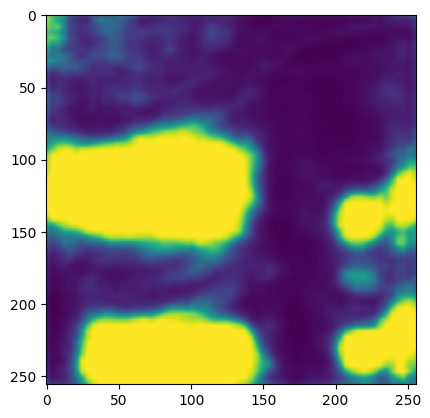

In [115]:
plt.imshow(outputs.softmax(1).cpu().detach().numpy()[0, 0])

In [ ]:
# torch.save(model, "fpn_200_epoch.pt")

In [ ]:
# test_data = UAVIDDataset(path="/mnt/processed_dataset/", is_train=False)
# test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
# test_iterator = iter(test_dataloader)

In [ ]:
# model.eval()
# test_feature, test_label = next(test_iterator)
# with torch.no_grad():
#     outputs = model(normalize(test_feature.to("cuda")))
#     outputs = outputs.to("cpu").softmax(axis=1)
#     visualize(test_feature, test_label, outputs)

# Attention Mode

In [ ]:
# def generate_positional_encoding(embedding_length, word_length):
#     half_embedding_length = embedding_length // 2

#     across_word = (
#         torch.arange(0, word_length).unsqueeze(0).T.repeat([1, half_embedding_length])
#     )
#     across_embedding = (
#         torch.arange(half_embedding_length).unsqueeze(0).repeat([word_length, 1])
#     )

#     sin_positional = torch.sin(
#         across_word / torch.pow(10000, across_embedding * 2 / half_embedding_length)
#     )
#     cos_positional = torch.cos(
#         across_word / torch.pow(10000, across_embedding * 2 / half_embedding_length)
#     )
#     output = torch.concat([sin_positional, cos_positional]).T.flatten()
#     return torch.stack(torch.split(output, word_length), dim=1).reshape(word_length, -1)


# class PositionEncoding(torch.nn.Module):
#     def __init__(self, embedding_length: int, max_word_length: int):
#         super().__init__()
#         self.positional_encoding = nn.Parameter(
#             generate_positional_encoding(
#                 embedding_length,
#                 max_word_length,
#             ).unsqueeze(1),
#             requires_grad=False,
#         )
#         self.embedding_length = embedding_length

#     def forward(self, x):
#         return x + self.positional_encoding[0 : x.shape[0]]


# class AttentionBlock(torch.nn.Module):
#     def __init__(self, embedding_length: int, word_length: int):
#         super().__init__()
#         self.positional_encoding = PositionEncoding(16 * 16 * 3, 3)
#         self.attention = nn.MultiheadAttention(
#             16 * 16 * 3,
#             8,
#             batch_first=True,
#         )

#     def forward(self, x):
#         x = self.positional_encoding(x)
#         attn_output, _ = self.attention(x, x, x, need_weights=False)
#         return attn_output


# class AttentionNetwork(nn.Module):
#     def __init__(self, numberClass):
#         super().__init__()
#         _resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
#         self.backbone = create_feature_extractor(
#             _resnet50,
#             {
#                 "relu": "feat1",
#                 "layer1": "feat2",
#                 "layer2": "feat3",
#                 "layer3": "feat4",
#                 "layer4": "feat5",
#             },
#         )

#         self.layer_1_conv = torch.nn.Conv2d(64, out_channels=3, kernel_size=1)
#         self.layer_2_conv = torch.nn.Conv2d(512, out_channels=3, kernel_size=1)
#         self.layer_3_conv = torch.nn.Conv2d(2048, out_channels=3, kernel_size=1)
#         self.attention_block = AttentionBlock(16 * 16 * 3, 3)
#         self.conv_1 = nn.Conv2d(
#             in_channels=2048, out_channels=256, kernel_size=3, padding=1
#         )
#         self.conv_2 = nn.Conv2d(
#             in_channels=512, out_channels=256, kernel_size=3, padding=1
#         )
#         self.conv_3 = nn.Conv2d(
#             in_channels=256, out_channels=256, kernel_size=3, padding=1
#         )
#         self.middle_embedding = nn.Conv2d(
#             in_channels=3,
#             out_channels=256,
#             kernel_size=1,
#         )
#         self.convfinal = nn.Conv2d(
#             in_channels=256, out_channels=numberClass, kernel_size=1
#         )

#     def forward(self, x):
#         backbone_output = self.backbone(x)
#         feat1, feat2, feat3, feat4, feat5 = (
#             backbone_output["feat1"],
#             backbone_output["feat2"],
#             backbone_output["feat3"],
#             backbone_output["feat4"],
#             backbone_output["feat5"],
#         )

#         # Only address attention for 3 layers
#         # feat1, feat3, feat5
#         layer_1 = torch.nn.functional.avg_pool2d(
#             self.layer_1_conv(feat1),
#             kernel_size=8,
#         )
#         layer_2 = torch.nn.functional.avg_pool2d(
#             self.layer_2_conv(feat3),
#             kernel_size=2,
#         )
#         layer_3 = torch.nn.functional.interpolate(
#             self.layer_3_conv(feat5),
#             size=16,
#         )

#         batch_size = layer_1.shape[0]
#         layer_1 = layer_1.reshape(batch_size, -1)
#         layer_2 = layer_2.reshape(batch_size, -1)
#         layer_3 = layer_3.reshape(batch_size, -1)
#         combined_output = torch.stack([layer_1, layer_2, layer_3])
#         attention_output = self.attention_block(combined_output)

#         output_1 = self.middle_embedding(
#             torch.nn.functional.interpolate(
#                 attention_output[0].reshape((batch_size, 3, 16, 16)),
#                 scale_factor=4,
#             )
#         )
#         output_2 = self.middle_embedding(
#             torch.nn.functional.interpolate(
#                 attention_output[1].reshape((batch_size, 3, 16, 16)),
#                 scale_factor=4,
#             )
#         )
#         output_3 = self.middle_embedding(
#             torch.nn.functional.interpolate(
#                 attention_output[2].reshape((batch_size, 3, 16, 16)),
#                 scale_factor=4,
#             )
#         )

#         return self.convfinal(
#             nn.functional.upsample_bilinear(
#                 (
#                     self.conv_1(
#                         nn.functional.interpolate(
#                             feat5, scale_factor=8, mode="bilinear"
#                         )
#                     )
#                     + output_3
#                 ).relu()
#                 + (
#                     self.conv_2(
#                         nn.functional.interpolate(
#                             feat3, scale_factor=2, mode="bilinear"
#                         )
#                     )
#                     + output_2
#                 ).relu()
#                 + (self.conv_3(feat2) + output_1).relu(),
#                 scale_factor=4,
#             ),
#         )


# model = AttentionNetwork(8)
# with torch.no_grad():
#     output = model(torch.rand(1, 3, 256, 256))
#     plt.figure(figsize=(9, 9))
#     plt.imshow(output[0, 0], interpolation="nearest", aspect="auto")